# Capstone Project: Restaurant Clustering Analysis - Downtown Toronto

## 1. Import Libraries and Create API Credentials

In [0]:
#Import libraries
import numpy as np # library for vectorized computation
import pandas as pd # library to process data as dataframes

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

!pip install --upgrade kmodes
from kmodes.kprototypes import KPrototypes

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
%matplotlib inline

import seaborn as sns



print('Libraries imported.')

Libraries imported.


In [0]:
#Create API Credentials
CLIENT_ID = 'J5TLXRXUA0ICKXBDP2DWBFZESZW0243VF3LK10DDXNU24ROU' # your Foursquare ID
CLIENT_SECRET = 'GZ2FIULN2FYFFNUWTAMXI0V2BI52TBRAN2KWTXMAHPAE20EX' # your Foursquare Secret
VERSION = '20200301' # Foursquare API version
ACCESS_TOKEN = '5EKRTSSTQP011KLGSYVCYGBIUH3J3Z0WE4XJ1VS3OT3E3QSY'

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: J5TLXRXUA0ICKXBDP2DWBFZESZW0243VF3LK10DDXNU24ROU
CLIENT_SECRET:GZ2FIULN2FYFFNUWTAMXI0V2BI52TBRAN2KWTXMAHPAE20EX


In [0]:
lat=43.653963
lng=-79.387207
radius=5000
INT='dinner'
LIMIT=1
QUERY='Restaurant'


In [0]:
# create the API request URL for Venue Search
url = 'https://api.foursquare.com/v2/search/recommendations?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&intent={}&oauth_token={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT,
            INT,
            ACCESS_TOKEN)
            
# make the GET request
results = requests.get(url).json()

In [0]:
# create the API request URL for Venue Details
url_r = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}&oauth_token={}'.format(
            VENUE_ID,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION,
            ACCESS_TOKEN)
            
# make the GET request
results_venue_ID = requests.get(url_r).json()

## 2. Data Import and Wrangling

Postal codes and Neighbourhoods datasets are imported from Wikipedia, Latitudes and Longitudes from the Geospatial Coordinates file. The combined dataset is grouped by Postal codes and Borough. The dataset is then filtered by the Borough "Downtown Toronto" and its respective Neighbourhoods.

In [0]:
# Get postal codes for Toronto's Neighbourhoods

toronto_postal=pd.read_html("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")[0]
toronto_postal_1=toronto_postal[toronto_postal.Borough != 'Not assigned']
toronto_postal_1.reset_index(drop=True, inplace=True)
strJoin = lambda x:", ".join(x.astype(str)) 
toronto_postal_2 = toronto_postal_1.groupby(['Postcode','Borough'])['Neighbourhood'].agg({"Neighbourhood":strJoin})
toronto_postal_2.reset_index(inplace=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

  """


In [0]:
# Get Latitude and Longitude for Toronto's Neighbourhoods
!wget -q -O 'Geospatial_Coordinates.csv' http://cocl.us/Geospatial_data
geo_data = pd.read_csv('Geospatial_Coordinates.csv')
toronto_postal_merged = pd.merge(left=toronto_postal_2, right=geo_data, left_on='Postcode', right_on='Postal Code')
toronto_postal_final=toronto_postal_merged.drop(columns=['Postal Code']).rename(columns={"Postcode": "Postalcode"})
downtown_data = toronto_postal_final[toronto_postal_final['Borough'] == 'Downtown Toronto'].reset_index(drop=True)
downtown_data.head()


,Postalcode,Borough,Neighbourhood,Latitude,Longitude
0,M4W,Downtown Toronto,Rosedale,43.679563,-79.377529
1,M4X,Downtown Toronto,"Cabbagetown, St. James Town",43.667967,-79.367675
2,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160
3,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636
4,M5B,Downtown Toronto,"Ryerson, Garden District",43.657162,-79.378937


Data is extracted from Foursquare's API based on the provided Latitudes and Longitudes for each group of Neighborhoods.  Venue ID, Venue Category will be used to filter the venues that contain any Restaurant value in Venue Category.

In [0]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT=100, QUERY='Restaurant'):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['id'],
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue ID',
                  'Venue Name', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [0]:
downtown_venues = getNearbyVenues(names=downtown_data['Neighbourhood'],
                                   latitudes=downtown_data['Latitude'],
                                   longitudes=downtown_data['Longitude']
                                  )

Rosedale
Cabbagetown, St. James Town
Church and Wellesley
Harbourfront
Ryerson, Garden District
St. James Town
Berczy Park
Central Bay Street
Adelaide, King, Richmond
Harbourfront East, Toronto Islands, Union Station
Design Exchange, Toronto Dominion Centre
Commerce Court, Victoria Hotel
Harbord, University of Toronto
Chinatown, Grange Park, Kensington Market
CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara
Stn A PO Boxes 25 The Esplanade
First Canadian Place, Underground city
Christie
Queen's Park


In [0]:
downtown_venues

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue ID,Venue Name,Venue Latitude,Venue Longitude,Venue Category
0,Rosedale,43.679563,-79.377529,4aff2d47f964a520743522e3,Rosedale Park,43.682328,-79.378934,Playground
1,Rosedale,43.679563,-79.377529,4bd777aa5cf276b054639b00,Whitney Park,43.682036,-79.373788,Park
2,Rosedale,43.679563,-79.377529,4d0e77df76cc37045715767c,Alex Murray Parkette,43.678300,-79.382773,Park
3,Rosedale,43.679563,-79.377529,4ef8f2a3775b54cdb5bdec7c,Milkman's Lane,43.676352,-79.373842,Trail
4,"Cabbagetown, St. James Town",43.667967,-79.367675,4b646a6ff964a5205cb12ae3,Cranberries,43.667843,-79.369407,Diner
...,...,...,...,...,...,...,...,...
1310,Queen's Park,43.662301,-79.389494,4c0f812d98102d7f8a44e506,Tim Hortons,43.658906,-79.388696,Coffee Shop
1311,Queen's Park,43.662301,-79.389494,4cc5e76091413704e955cc55,SUDS,43.659880,-79.394712,Bar
1312,Queen's Park,43.662301,-79.389494,4b7c2a57f964a5208c812fe3,Tim Hortons,43.659415,-79.391221,Coffee Shop
1313,Queen's Park,43.662301,-79.389494,540e1fa1498e9b339bc79212,The Green Beet Cafe,43.662096,-79.394153,Vegetarian / Vegan Restaurant


In [0]:
# Filter Venue Category by Restaurant
downtown_restaurants = downtown_venues[downtown_venues['Venue Category'].str.contains('Restaurant')].reset_index(drop=True)

In [0]:
downtown_restaurants


,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue ID,Venue Name,Venue Latitude,Venue Longitude,Venue Category
0,"Cabbagetown, St. James Town",43.667967,-79.367675,4c8c21fdf0ce236ab28e15ef,Butter Chicken Factory,43.667072,-79.369184,Indian Restaurant
1,"Cabbagetown, St. James Town",43.667967,-79.367675,50cc21c37ab4d9c0594b6994,Kingyo Toronto,43.665895,-79.368415,Japanese Restaurant
2,"Cabbagetown, St. James Town",43.667967,-79.367675,4e4e7aa06365e1419d021044,F'Amelia,43.667536,-79.368613,Italian Restaurant
3,"Cabbagetown, St. James Town",43.667967,-79.367675,5412007d498e1e2d959ac35e,Murgatroid,43.667381,-79.369311,Restaurant
4,"Cabbagetown, St. James Town",43.667967,-79.367675,4b17c9f5f964a5202fc823e3,Mr. Jerk,43.667328,-79.373389,Caribbean Restaurant
...,...,...,...,...,...,...,...,...
322,Queen's Park,43.662301,-79.389494,566387f1498e4003e174ef72,The Captain's Boil,43.662375,-79.383535,Seafood Restaurant
323,Queen's Park,43.662301,-79.389494,4ae201e1f964a520bb8921e3,Wendy's,43.662820,-79.383379,Fast Food Restaurant
324,Queen's Park,43.662301,-79.389494,4c792e4981bca093af5efc14,Crown Princess Fine Dining 伯爵名宴,43.666455,-79.387698,Chinese Restaurant
325,Queen's Park,43.662301,-79.389494,540e1fa1498e9b339bc79212,The Green Beet Cafe,43.662096,-79.394153,Vegetarian / Vegan Restaurant


In [0]:
#downtown_restaurants.to_csv("downtown_restaurants.csv", index=False)

In [0]:
downtown_restaurants = pd.read_csv('downtown_restaurants.csv')


In [0]:
# Dedupe by Venue ID
downtown_restaurants_final=downtown_restaurants.drop_duplicates(subset=['Venue ID'], keep=False)

In [0]:
downtown_restaurants_final.reset_index(inplace=True, drop=True)
downtown_restaurants_final

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue ID,Venue Name,Venue Latitude,Venue Longitude,Venue Category
0,"Cabbagetown, St. James Town",43.667967,-79.367675,4c8c21fdf0ce236ab28e15ef,Butter Chicken Factory,43.667072,-79.369184,Indian Restaurant
1,"Cabbagetown, St. James Town",43.667967,-79.367675,50cc21c37ab4d9c0594b6994,Kingyo Toronto,43.665895,-79.368415,Japanese Restaurant
2,"Cabbagetown, St. James Town",43.667967,-79.367675,4e4e7aa06365e1419d021044,F'Amelia,43.667536,-79.368613,Italian Restaurant
3,"Cabbagetown, St. James Town",43.667967,-79.367675,5412007d498e1e2d959ac35e,Murgatroid,43.667381,-79.369311,Restaurant
4,"Cabbagetown, St. James Town",43.667967,-79.367675,4b17c9f5f964a5202fc823e3,Mr. Jerk,43.667328,-79.373389,Caribbean Restaurant
...,...,...,...,...,...,...,...,...
137,Stn A PO Boxes 25 The Esplanade,43.646435,-79.374846,4b2d7d0ff964a520b5d724e3,Mirto,43.650702,-79.376307,Italian Restaurant
138,Christie,43.669542,-79.422564,4b003cf6f964a520d73b22e3,Vinny’s Panini,43.670679,-79.426148,Italian Restaurant
139,Christie,43.669542,-79.422564,4f737b84e4b060af1b23c5b7,Actinolite,43.667858,-79.428054,Restaurant
140,Queen's Park,43.662301,-79.389494,540e1fa1498e9b339bc79212,The Green Beet Cafe,43.662096,-79.394153,Vegetarian / Vegan Restaurant


Next step is to obtain the Restaurant Stats dataset using the Venue ID of each restaurant in the API call. This dataset includes the following measures: Rating, Rating Signals, Likes, Listed, Photos, Tips and Price Tier.  Only the Restaurants with Rating and Price Tier are included in the dataset.

In [0]:
# Get Restaurant Stats
def getVenuesStats(VENUE_ID):
    
    res_list=[]
    for id in (VENUE_ID):
        print(id)
            
        # create the API request URL
        url_res = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(
            id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
            
        # make the GET request
        results_res = requests.get(url_res).json()['response']['venue']
        if results_res.get('rating', None) and results_res.get('price', None):
          res_list.append([( 
            id, 
            results_res['name'],
            results_res['rating'],
            results_res['ratingSignals'],
            results_res['likes']['count'],
            results_res['tips']['count'],
            results_res['listed']['count'],
            results_res['photos']['count'],
            results_res['price']['tier']
            )])
            
        else:
          res_list.append([(id, results_res['name'],'Nan','Nan','Nan','Nan','Nan','Nan','Nan')])

    res_venues = pd.DataFrame([item for venue_list in res_list for item in venue_list])
    res_venues.columns = ['Restaurant ID', 
                  'Restaurant Name',
                  'Rating',
                  'Rating Signals',
                  'Likes',
                  'Tips',
                  'Listed',
                  'Photos',
                  'Price Tier']
    
    return(res_venues)

    # filter_columns=['categories','rating','ratingSignals','likes.count','tips.count','listed.count','price.tier','photos.count'

In [0]:
downtown_venues_restaurants = getVenuesStats(VENUE_ID=downtown_restaurants['Venue ID'])

In [0]:
downtown_venues_restaurants

,Restaurant ID,Restaurant Name,Rating,Rating Signals,Likes,Tips,Listed,Photos,Price Tier
0,4c8c21fdf0ce236ab28e15ef,Butter Chicken Factory,8.5,28,18,10,33,4,2
1,50cc21c37ab4d9c0594b6994,Kingyo Toronto,8.8,161,113,54,186,262,2
2,4e4e7aa06365e1419d021044,F'Amelia,8.2,45,30,17,56,35,2
3,5412007d498e1e2d959ac35e,Murgatroid,8.2,25,16,9,14,12,2
4,4b17c9f5f964a5202fc823e3,Mr. Jerk,8.4,30,19,18,21,15,2
...,...,...,...,...,...,...,...,...,...
322,566387f1498e4003e174ef72,The Captain's Boil,7.5,64,40,16,22,54,3
323,4ae201e1f964a520bb8921e3,Wendy's,7.6,99,66,16,3,52,1
324,4c792e4981bca093af5efc14,Crown Princess Fine Dining 伯爵名宴,7.4,107,67,28,62,121,3
325,540e1fa1498e9b339bc79212,The Green Beet Cafe,Nan,Nan,Nan,Nan,Nan,Nan,Nan


In [0]:
#downtown_venues_restaurants.to_csv("downtown_venues_restaurants.csv", index=False)

In [0]:
downtown_venues_restaurants = pd.read_csv('downtown_venues_restaurants.csv')

In [0]:
downtown_restaurants_stats=downtown_venues_restaurants[downtown_venues_restaurants.Rating != 'Nan']

In [0]:
downtown_restaurants_stats_final=downtown_restaurants_stats.drop_duplicates(subset=['Restaurant ID'], keep=False)

In [0]:
downtown_restaurants_stats_final.reset_index(inplace=True, drop=True)

In [0]:
downtown_restaurants_stats_final

,Restaurant ID,Restaurant Name,Rating,Rating Signals,Likes,Tips,Listed,Photos,Price Tier
0,4c8c21fdf0ce236ab28e15ef,Butter Chicken Factory,8.5,28,18,10,33,4,2
1,50cc21c37ab4d9c0594b6994,Kingyo Toronto,8.8,161,113,54,186,262,2
2,4e4e7aa06365e1419d021044,F'Amelia,8.2,45,30,17,56,35,2
3,5412007d498e1e2d959ac35e,Murgatroid,8.2,25,16,9,14,12,2
4,4b17c9f5f964a5202fc823e3,Mr. Jerk,8.4,30,19,18,21,15,2
...,...,...,...,...,...,...,...,...,...
124,50e6282de4b026ac78e0ee70,Pho Tien,6.0,13,7,1,3,3,2
125,51a15add498e3fa3478d2d9c,Woods Restaurant & Bar,7.8,48,27,16,32,38,2
126,4b2d7d0ff964a520b5d724e3,Mirto,7.4,15,6,7,6,7,2
127,4b003cf6f964a520d73b22e3,Vinny’s Panini,7.8,12,6,6,11,5,2


Downtown Restuarants and Restaurant Stats Datasets are merged using the Venue ID as primary key.


In [0]:
downtown_restaurants_merged = pd.merge(left=downtown_restaurants_stats_final, right=downtown_restaurants_final, left_on='Restaurant ID', right_on='Venue ID')

In [0]:
downtown_restaurants_merged.reset_index(inplace=True, drop=True)


,Restaurant ID,Restaurant Name,Rating,Rating Signals,Likes,Tips,Listed,Photos,Price Tier,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue ID,Venue Name,Venue Latitude,Venue Longitude,Venue Category
0,4c8c21fdf0ce236ab28e15ef,Butter Chicken Factory,8.5,28,18,10,33,4,2,"Cabbagetown, St. James Town",43.667967,-79.367675,4c8c21fdf0ce236ab28e15ef,Butter Chicken Factory,43.667072,-79.369184,Indian Restaurant
1,50cc21c37ab4d9c0594b6994,Kingyo Toronto,8.8,161,113,54,186,262,2,"Cabbagetown, St. James Town",43.667967,-79.367675,50cc21c37ab4d9c0594b6994,Kingyo Toronto,43.665895,-79.368415,Japanese Restaurant
2,4e4e7aa06365e1419d021044,F'Amelia,8.2,45,30,17,56,35,2,"Cabbagetown, St. James Town",43.667967,-79.367675,4e4e7aa06365e1419d021044,F'Amelia,43.667536,-79.368613,Italian Restaurant
3,5412007d498e1e2d959ac35e,Murgatroid,8.2,25,16,9,14,12,2,"Cabbagetown, St. James Town",43.667967,-79.367675,5412007d498e1e2d959ac35e,Murgatroid,43.667381,-79.369311,Restaurant
4,4b17c9f5f964a5202fc823e3,Mr. Jerk,8.4,30,19,18,21,15,2,"Cabbagetown, St. James Town",43.667967,-79.367675,4b17c9f5f964a5202fc823e3,Mr. Jerk,43.667328,-79.373389,Caribbean Restaurant
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,50e6282de4b026ac78e0ee70,Pho Tien,6.0,13,7,1,3,3,2,"Chinatown, Grange Park, Kensington Market",43.653206,-79.400049,50e6282de4b026ac78e0ee70,Pho Tien,43.652832,-79.406242,Vietnamese Restaurant
125,51a15add498e3fa3478d2d9c,Woods Restaurant & Bar,7.8,48,27,16,32,38,2,Stn A PO Boxes 25 The Esplanade,43.646435,-79.374846,51a15add498e3fa3478d2d9c,Woods Restaurant & Bar,43.649357,-79.375002,Molecular Gastronomy Restaurant
126,4b2d7d0ff964a520b5d724e3,Mirto,7.4,15,6,7,6,7,2,Stn A PO Boxes 25 The Esplanade,43.646435,-79.374846,4b2d7d0ff964a520b5d724e3,Mirto,43.650702,-79.376307,Italian Restaurant
127,4b003cf6f964a520d73b22e3,Vinny’s Panini,7.8,12,6,6,11,5,2,Christie,43.669542,-79.422564,4b003cf6f964a520d73b22e3,Vinny’s Panini,43.670679,-79.426148,Italian Restaurant


In [0]:
downtown_restaurants_merged_final=downtown_restaurants_merged.drop(columns=['Venue ID','Venue Name']).rename(columns={"Venue Category": "Restaurant Category"})
downtown_restaurants_merged_final

,Restaurant ID,Restaurant Name,Rating,Rating Signals,Likes,Tips,Listed,Photos,Price Tier,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue Latitude,Venue Longitude,Restaurant Category
0,4c8c21fdf0ce236ab28e15ef,Butter Chicken Factory,8.5,28,18,10,33,4,2,"Cabbagetown, St. James Town",43.667967,-79.367675,43.667072,-79.369184,Indian Restaurant
1,50cc21c37ab4d9c0594b6994,Kingyo Toronto,8.8,161,113,54,186,262,2,"Cabbagetown, St. James Town",43.667967,-79.367675,43.665895,-79.368415,Japanese Restaurant
2,4e4e7aa06365e1419d021044,F'Amelia,8.2,45,30,17,56,35,2,"Cabbagetown, St. James Town",43.667967,-79.367675,43.667536,-79.368613,Italian Restaurant
3,5412007d498e1e2d959ac35e,Murgatroid,8.2,25,16,9,14,12,2,"Cabbagetown, St. James Town",43.667967,-79.367675,43.667381,-79.369311,Restaurant
4,4b17c9f5f964a5202fc823e3,Mr. Jerk,8.4,30,19,18,21,15,2,"Cabbagetown, St. James Town",43.667967,-79.367675,43.667328,-79.373389,Caribbean Restaurant
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,50e6282de4b026ac78e0ee70,Pho Tien,6.0,13,7,1,3,3,2,"Chinatown, Grange Park, Kensington Market",43.653206,-79.400049,43.652832,-79.406242,Vietnamese Restaurant
125,51a15add498e3fa3478d2d9c,Woods Restaurant & Bar,7.8,48,27,16,32,38,2,Stn A PO Boxes 25 The Esplanade,43.646435,-79.374846,43.649357,-79.375002,Molecular Gastronomy Restaurant
126,4b2d7d0ff964a520b5d724e3,Mirto,7.4,15,6,7,6,7,2,Stn A PO Boxes 25 The Esplanade,43.646435,-79.374846,43.650702,-79.376307,Italian Restaurant
127,4b003cf6f964a520d73b22e3,Vinny’s Panini,7.8,12,6,6,11,5,2,Christie,43.669542,-79.422564,43.670679,-79.426148,Italian Restaurant


In [0]:
#downtown_restaurants_merged_final.to_csv("downtown_restaurants_merged_final.csv", index=False)

In [0]:
downtown_restaurants_merged_final=pd.read_csv("downtown_restaurants_merged_final.csv")

In [0]:
downtown_restaurants_merged_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129 entries, 0 to 128
Data columns (total 15 columns):
Restaurant ID              129 non-null object
Restaurant Name            129 non-null object
Rating                     129 non-null float64
Rating Signals             129 non-null int64
Likes                      129 non-null int64
Tips                       129 non-null int64
Listed                     129 non-null int64
Photos                     129 non-null int64
Price Tier                 129 non-null int64
Neighbourhood              129 non-null object
Neighbourhood Latitude     129 non-null float64
Neighbourhood Longitude    129 non-null float64
Venue Latitude             129 non-null float64
Venue Longitude            129 non-null float64
Restaurant Category        129 non-null object
dtypes: float64(5), int64(6), object(4)
memory usage: 15.2+ KB


One hot encoding for Restaurant Category's categorical values

In [0]:
# one hot encoding
restaurants_onehot = pd.get_dummies(downtown_restaurants_merged_final[['Restaurant Category']], prefix="", prefix_sep="")


,Afghan Restaurant,American Restaurant,Asian Restaurant,Caribbean Restaurant,Chinese Restaurant,Comfort Food Restaurant,Dim Sum Restaurant,Doner Restaurant,Dumpling Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Greek Restaurant,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,New American Restaurant,Ramen Restaurant,Restaurant,Seafood Restaurant,Sushi Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
125,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
126,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
127,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
restaurants_onehot_final = downtown_restaurants_merged_final.join(restaurants_onehot)


In [0]:
restaurants_onehot_final.drop(columns=['Restaurant ID','Restaurant Name','Neighbourhood Latitude', 'Neighbourhood Longitude', 'Venue Latitude', 'Venue Longitude','Restaurant Category'], inplace=True)

In [0]:
restaurants_onehot_final

,Rating,Rating Signals,Likes,Tips,Listed,Photos,Price Tier,Neighbourhood,Afghan Restaurant,American Restaurant,Asian Restaurant,Caribbean Restaurant,Chinese Restaurant,Comfort Food Restaurant,Dim Sum Restaurant,Doner Restaurant,Dumpling Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Greek Restaurant,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,New American Restaurant,Ramen Restaurant,Restaurant,Seafood Restaurant,Sushi Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,8.5,28,18,10,33,4,2,"Cabbagetown, St. James Town",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,8.8,161,113,54,186,262,2,"Cabbagetown, St. James Town",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,8.2,45,30,17,56,35,2,"Cabbagetown, St. James Town",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,8.2,25,16,9,14,12,2,"Cabbagetown, St. James Town",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,8.4,30,19,18,21,15,2,"Cabbagetown, St. James Town",0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,6.0,13,7,1,3,3,2,"Chinatown, Grange Park, Kensington Market",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
125,7.8,48,27,16,32,38,2,Stn A PO Boxes 25 The Esplanade,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
126,7.4,15,6,7,6,7,2,Stn A PO Boxes 25 The Esplanade,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
127,7.8,12,6,6,11,5,2,Christie,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
restaurants_onehot_final_df = restaurants_onehot_final[['Neighbourhood'] + [ col for col in restaurants_onehot_final.columns if col != 'Neighbourhood' ] ]

In [0]:
# one hot encoded dataset
restaurants_onehot_final_df

,Neighbourhood,Rating,Rating Signals,Likes,Tips,Listed,Photos,Price Tier,Afghan Restaurant,American Restaurant,Asian Restaurant,Caribbean Restaurant,Chinese Restaurant,Comfort Food Restaurant,Dim Sum Restaurant,Doner Restaurant,Dumpling Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Greek Restaurant,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,New American Restaurant,Ramen Restaurant,Restaurant,Seafood Restaurant,Sushi Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,"Cabbagetown, St. James Town",8.5,28,18,10,33,4,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"Cabbagetown, St. James Town",8.8,161,113,54,186,262,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,"Cabbagetown, St. James Town",8.2,45,30,17,56,35,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,"Cabbagetown, St. James Town",8.2,25,16,9,14,12,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,"Cabbagetown, St. James Town",8.4,30,19,18,21,15,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,"Chinatown, Grange Park, Kensington Market",6.0,13,7,1,3,3,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
125,Stn A PO Boxes 25 The Esplanade,7.8,48,27,16,32,38,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
126,Stn A PO Boxes 25 The Esplanade,7.4,15,6,7,6,7,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
127,Christie,7.8,12,6,6,11,5,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
#restaurants_onehot_final_df.to_csv('restaurants_onehot_final_df.csv')
restaurants_onehot_final = pd.read_csv('/content/drive/My Drive/Colab Notebooks/restaurants_onehot_final_df.csv')

In [0]:
# Define Feature set 
X = restaurants_onehot_final.drop(columns=['Neighbourhood','Unnamed: 0'])

In [0]:
X

,Rating,Rating Signals,Likes,Tips,Listed,Photos,Price Tier,Afghan Restaurant,American Restaurant,Asian Restaurant,Caribbean Restaurant,Chinese Restaurant,Comfort Food Restaurant,Dim Sum Restaurant,Doner Restaurant,Dumpling Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Greek Restaurant,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,New American Restaurant,Ramen Restaurant,Restaurant,Seafood Restaurant,Sushi Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,8.5,28,18,10,33,4,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,8.8,161,113,54,186,262,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,8.2,45,30,17,56,35,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,8.2,25,16,9,14,12,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,8.4,30,19,18,21,15,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,6.0,13,7,1,3,3,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
125,7.8,48,27,16,32,38,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
126,7.4,15,6,7,6,7,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
127,7.8,12,6,6,11,5,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## 3. Exploratory Data Analysis

Data visualization is performed for each feature (measures) of the X dataset. Histograms show that Likes, Listed, Photos and Rating Signals have similar distributions. Rating's distribution indicates that most of the restaurant ratings are between 7.0 and 8.5. Price Tier distribution shows that most of the restaurants are "Moderate" in terms of pricing.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use 

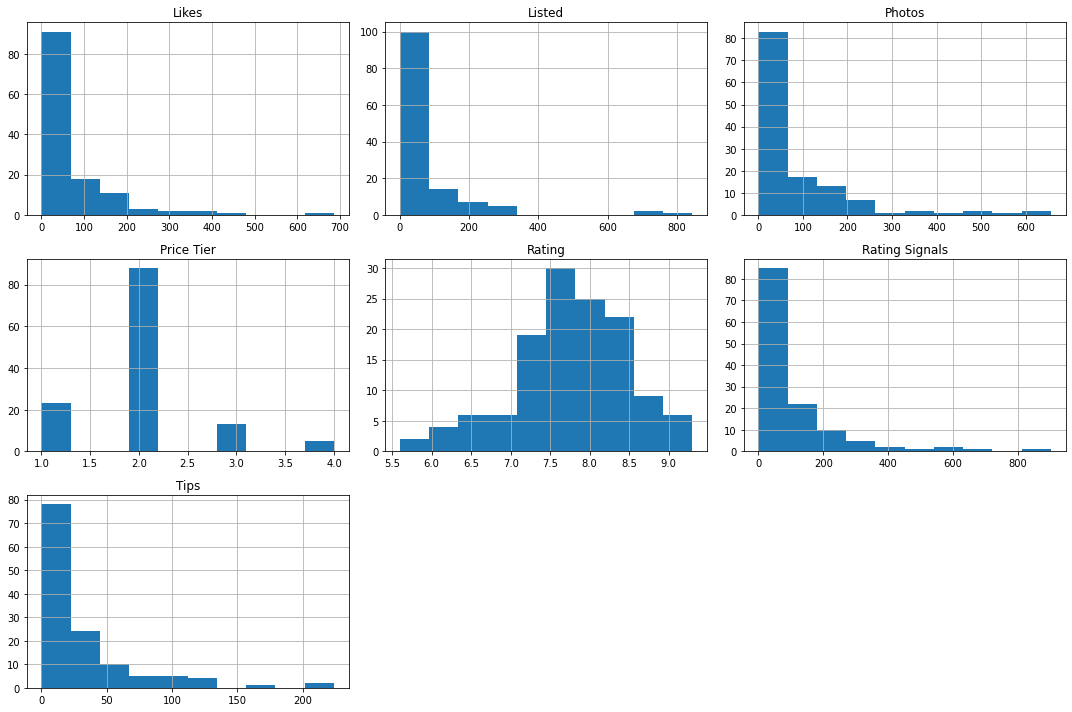

In [0]:
#Feature Distribution
f, ax = plt.subplots(figsize=(15,10))
Cluster_Restaurants_Final[features].hist(ax=ax);
plt.tight_layout()

The correlation analysis shows that Rating Signals is highly correlated to Likes, Photos, Tips and Listed features.  This means that Rating Signals can be used as a proxy for customer engagement and referral.

Text(0.5, 1.0, 'Features Correlation Heatmap')

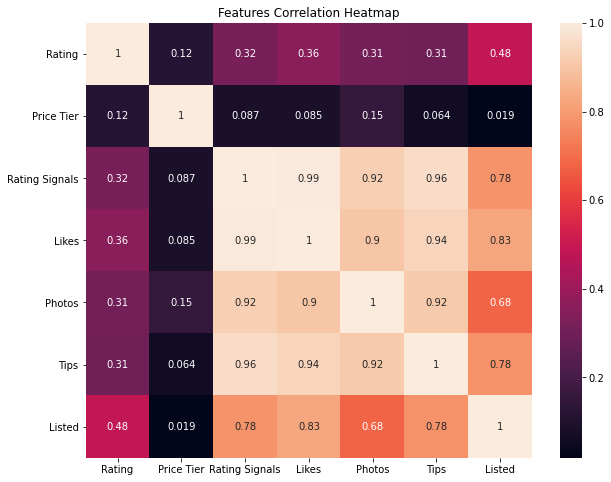

In [0]:
# Feature Correlation
features = [
    'Rating',
    'Price Tier',
    'Rating Signals', 'Likes', 'Photos', 'Tips', 'Listed']

f,ax = plt.subplots(figsize=(10,8))
sns.heatmap(Cluster_Restaurants_Final[features].corr(), ax=ax, annot=True)
ax.set_title("Features Correlation Heatmap")

## 4. Feature Preprocessing

Feature Preprocessing using Standard Scaler applied to feature dataset X

In [0]:
from sklearn.preprocessing import StandardScaler
sscaler = StandardScaler()
cluster_restaurants = sscaler.fit_transform(X)
cluster_restaurants

array([[ 1.030164  , -0.53366317, -0.51169861, ..., -0.22086305,
        -0.22086305, -0.23953507],
       [ 1.44458549,  0.39063109,  0.45438774, ..., -0.22086305,
        -0.22086305, -0.23953507],
       [ 0.61574252, -0.41552029, -0.38966665, ..., -0.22086305,
        -0.22086305, -0.23953507],
       ...,
       [-0.48938144, -0.62400772, -0.63373057, ..., -0.22086305,
        -0.22086305, -0.23953507],
       [ 0.06318054, -0.64485646, -0.63373057, ..., -0.22086305,
        -0.22086305, -0.23953507],
       [-0.48938144, -0.50586484, -0.48119062, ..., -0.22086305,
        -0.22086305, -0.23953507]])

## 5. Machine Learning Model

The K-Prototypes clustering algorithm is applied to the feature dataset.  The feature dataset contains both categorical and numerical variables and according to statistical literature K-Prototypes is more suitable in this case than using K-Mean. 

The goal with K-Prototypes is to cluster the restuarants in the different Downtown Toronto's Neighbourhoods and get insights based on the features included in the dataset.

As a first step, the optimal number is calculated based on the K-Prototypes cost.  The resulting curve's elbow indicates that K should be 3.

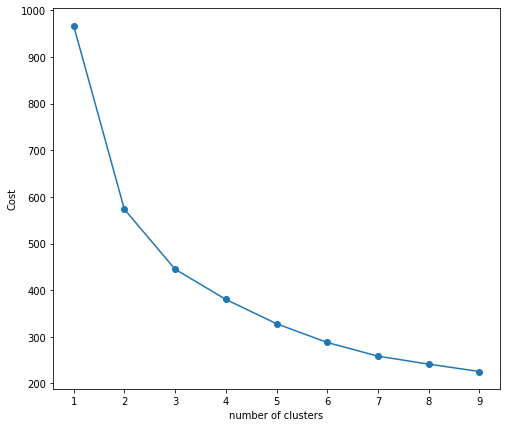

In [0]:
#Choosing optimal K

cost = []

for num_clusters in list(range(1,10)):
    kproto = KPrototypes(n_clusters=num_clusters, init='Cao')
    kproto.fit_predict(cluster_restaurants, categorical=[7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39])
    cost.append(kproto.cost_)
    
fig, ax1 = plt.subplots(1,1, sharex=False, figsize=(8,7))
ax1.plot(range(1,10), cost,marker="o")
ax1.set_ylabel("Cost")
ax1.set_xlabel('number of clusters')
    
plt.show()



Second step is to apply the K-Prototypes Algorithm to the standarized feature dataset and obtain the resulting labels for each cluster (0,1,2)

In [0]:
#Clustering with the K-Prototypes Algorithm
kproto = KPrototypes(n_clusters=3, init='Cao')
kproto.fit(cluster_restaurants, categorical=[7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39])
labels = kproto.labels_

print(labels)

[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 2 0 2 0
 1 2 1 0 2 1 0 1 0 0 0 0 1 0 1 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 2 1
 1 0 1 0 1 1 0 0 0 0 0 0 0 2 1 0 0 0 1 0 0 0 0 0 0 0 2 0 0 0 0 1 0 0 1 1 0
 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]


Third step is to include the labels in the downtown restaurant and restaurant stats datasets for further Cluster Analysis.

In [0]:
Cluster_Restaurants_Final = downtown_restaurants_merged_final

In [0]:
Cluster_Restaurants_Final.insert(0, 'Cluster Labels', labels)

In [0]:
Cluster_Restaurants_Final.to_csv('Cluster_Restaurants_Final.csv', index=False)

In [0]:
#Cluster_Restaurants_Final.drop(columns='Unnamed: 0', inplace=True)

In [0]:
Cluster_Restaurants_Final=pd.read_csv("/content/drive/My Drive/Cluster_Restaurants_Final.csv")

In [0]:
Cluster_Restaurants_Final.head()

,Cluster Labels,Restaurant ID,Restaurant Name,Rating,Rating Signals,Likes,Tips,Listed,Photos,Price Tier,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue Latitude,Venue Longitude,Restaurant Category
0,0,4c8c21fdf0ce236ab28e15ef,Butter Chicken Factory,8.5,28,18,10,33,4,2,"Cabbagetown, St. James Town",43.667967,-79.367675,43.667072,-79.369184,Indian Restaurant
1,1,50cc21c37ab4d9c0594b6994,Kingyo Toronto,8.8,161,113,54,186,262,2,"Cabbagetown, St. James Town",43.667967,-79.367675,43.665895,-79.368415,Japanese Restaurant
2,0,4e4e7aa06365e1419d021044,F'Amelia,8.2,45,30,17,56,35,2,"Cabbagetown, St. James Town",43.667967,-79.367675,43.667536,-79.368613,Italian Restaurant
3,0,5412007d498e1e2d959ac35e,Murgatroid,8.2,25,16,9,14,12,2,"Cabbagetown, St. James Town",43.667967,-79.367675,43.667381,-79.369311,Restaurant
4,0,4b17c9f5f964a5202fc823e3,Mr. Jerk,8.4,30,19,18,21,15,2,"Cabbagetown, St. James Town",43.667967,-79.367675,43.667328,-79.373389,Caribbean Restaurant


## 6. Results Section

For visualization purposes the resulting clusters are included as markers on a Toronto map.  Each cluster is identified by its respective cluster label, which is used as a marker on the map(0,1,2). 

In [0]:
# set Toronto Map location
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


In [0]:
# create Toronto Map with cluster markers

num_clusters = 3
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=14, tiles = "cartodbpositron")

# set color scheme for the clusters
x = np.arange(num_clusters)
ys = [i + x + (i*x)**2 for i in range(num_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Cluster_Restaurants_Final['Venue Latitude'], Cluster_Restaurants_Final['Venue Longitude'], Cluster_Restaurants_Final['Neighbourhood'], Cluster_Restaurants_Final['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster Labels ' + str(cluster), parse_html=True)
    icon = folium.DivIcon(html=str(cluster))
    folium.Marker([lat, lon], icon=icon).add_to(map_clusters)

map_clusters

The map shows how the different clusters are distributed in each neighbourhood.  Most of the restaurants are located in Chinatown/Grange Park/Kensignton Market, Church and Wellesley and Central Bay Street.  

Cluster 0 is the most representative on those neighbourhoods and overall.  Cluster 1 is mainly present in Chinatown/Grange Park/Kensignton Market, Ryerson/Garden District, St James Town.  Cluster 2 is predomently in Ryerson/Garden District, Harbourfront, Adeleaide/King/Richmond.

Ryerson/Garden District, Harbourfront, Design Exchange, Adeleaide/King/Richmond are neighbourhoods that include a good balanced mix of number of restaurants per cluster.

Looking at the distribution of cluster labels per Restaurant Category, it indicates that Restaurant (local cuisine), Japanese Restaurant and Italian Restaurant are the most common categories in Cluster 0. Cluster 1 is very similar only adding Sushi and Mexican restaurant categories.  Cluster 2 includes mostly Mexican, Ramen, Restaurant (local), Japanese and Thai categories.

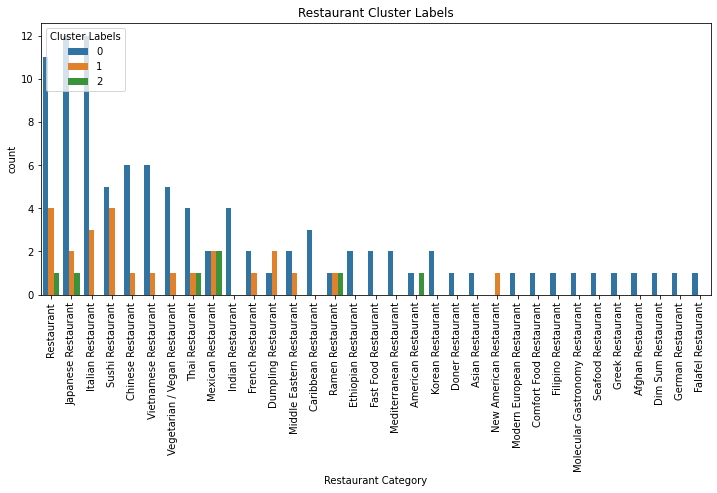

In [0]:
# Count Plot Restaurant Cluster Labels per Restaurant Category
f, ax1 = plt.subplots(1,1, figsize=(12,5))
descending_order_c = Cluster_Restaurants_Final['Restaurant Category'].value_counts().sort_values(ascending=False).index
sns.countplot(Cluster_Restaurants_Final['Restaurant Category'], ax=ax1, hue=Cluster_Restaurants_Final["Cluster Labels"], order=descending_order_c)
ax1.set_title('Restaurant Cluster Labels')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90);

Looking at the distribution of cluster labels by Price Tier, Cluster 0 groups most of the 'Cheap' and 'Moderate' Price Tier restaurants.  Cluster 1 has a good mix of Price Tiers. Cluster 2 doesn't include the 'Very Expensive' Price Tier.

Text(0.5, 1.0, 'Restaurant Cluster Labels')

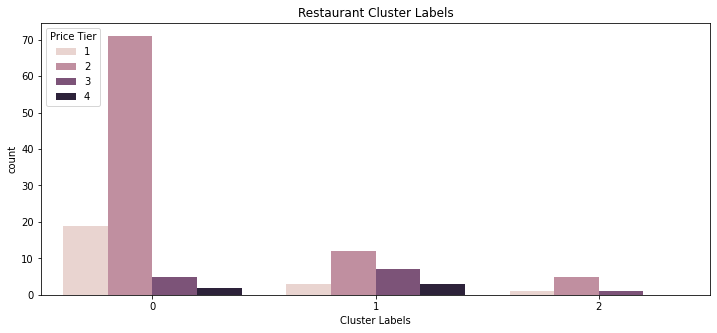

In [0]:
# Count plot for Cluster Labels by Price Tier
f, ax1 = plt.subplots(1,1, figsize=(12,5))
sns.countplot(Cluster_Restaurants_Final['Cluster Labels'], ax=ax1, hue=Cluster_Restaurants_Final["Price Tier"], palette=sns.cubehelix_palette(4))
ax1.set_title('Restaurant Clusters by Price Tier')

For the cluster analysis, each cluster's characteristics is identified by looking at its Cluster Center (Centroid) for each feature and cluster.

**Cluster 0:** <br>
Rating, Price Tier and Rating Signals for this cluster are all below average. For the Restaurant Categories the following are above average: Afghan, Asian, Caribbean, Chinese, Comfort Food, Dim Sum, Doner, Ethiopian, Falafel, Fast Food, Filipino, German, Greek, Indian, Italian, Korean, Mediterranean, Modern European, Molecular, Seafood, Vegan, Vietnamese.

**Cluster 1:** <br>
This cluster has Price Tier high/above average and Rating Signals, Rating below average. For the Restaurant Categories the following are above average: Sushi, Local Restaurant, New American, Middle Eastearn, French, Dumpling, Italian.

**Cluster 2:** <br>
Rating, and Rating Signals are well above average in this cluster, with a just below average Price Tier.
For the Restaurant Categories the following are above average: American, Japanese, Mexican, Ramen, Thai

Rating Signals feature is used as a proxy for other related engagement features: Likes, Photos, Listed, Tips.



In [0]:
#Calculate Mean of Cluster Centers for each cluster/feature
X_centroids_0 = X[kproto.labels_ == 0].mean(0)
X_centroids_1 = X[kproto.labels_ == 1].mean(0)
X_centroids_2 = X[kproto.labels_ == 2].mean(0)
df_centroids = pd.DataFrame([X_centroids_0, X_centroids_1, X_centroids_2])

In [0]:
df_centroids

,Rating,Rating Signals,Likes,Tips,Listed,Photos,Price Tier,Afghan Restaurant,American Restaurant,Asian Restaurant,Caribbean Restaurant,Chinese Restaurant,Comfort Food Restaurant,Dim Sum Restaurant,Doner Restaurant,Dumpling Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Greek Restaurant,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,New American Restaurant,Ramen Restaurant,Restaurant,Seafood Restaurant,Sushi Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,7.600000,44.154639,27.907216,13.907216,26.298969,34.391753,1.896907,0.010309,0.010309,0.010309,0.030928,0.061856,0.010309,0.010309,0.010309,0.010309,0.020619,0.010309,0.020619,0.010309,0.020619,0.010309,0.010309,0.041237,0.123711,0.123711,0.020619,0.020619,0.020619,0.020619,0.010309,0.010309,0.00,0.010309,0.113402,0.010309,0.051546,0.041237,0.051546,0.061856
1,8.196000,206.240000,133.560000,61.360000,142.880000,187.160000,2.400000,0.000000,0.000000,0.000000,0.000000,0.040000,0.000000,0.000000,0.000000,0.080000,0.000000,0.000000,0.000000,0.000000,0.040000,0.000000,0.000000,0.000000,0.120000,0.080000,0.000000,0.000000,0.080000,0.040000,0.000000,0.000000,0.04,0.040000,0.160000,0.000000,0.160000,0.040000,0.040000,0.040000
2,8.314286,582.714286,395.285714,149.857143,423.142857,506.000000,2.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.285714,0.000000,0.000000,0.000000,0.00,0.142857,0.142857,0.000000,0.000000,0.142857,0.000000,0.000000


In [0]:
#Standarize Mean of Cluster Centers
df_centroids_std = (df_centroids - df_centroids.mean()) / df_centroids.std()

In [0]:
df_centroids_std

,Rating,Rating Signals,Likes,Tips,Listed,Photos,Price Tier,Afghan Restaurant,American Restaurant,Asian Restaurant,Caribbean Restaurant,Chinese Restaurant,Comfort Food Restaurant,Dim Sum Restaurant,Doner Restaurant,Dumpling Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Greek Restaurant,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,New American Restaurant,Ramen Restaurant,Restaurant,Seafood Restaurant,Sushi Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,-1.140839,-0.845270,-0.833680,-0.886005,-0.839051,-0.864926,-0.760353,1.154701,-0.511440,1.154701,1.154701,0.889556,1.154701,1.154701,1.154701,-0.454838,1.154701,1.154701,1.154701,1.154701,0.020615,1.154701,1.154701,1.154701,0.603517,0.254154,1.154701,1.154701,-0.777472,0.020615,1.154701,1.154701,-0.577350,-0.777472,-1.075631,1.154701,-0.232267,-0.566840,0.777472,0.889556
1,0.415936,-0.258642,-0.275066,-0.198282,-0.267493,-0.230053,1.132770,-0.577350,-0.640841,-0.577350,-0.577350,0.192810,-0.577350,-0.577350,-0.577350,1.146572,-0.577350,-0.577350,-0.577350,-0.577350,0.989533,-0.577350,-0.577350,-0.577350,0.550782,-1.102553,-0.577350,-0.577350,-0.350624,0.989533,-0.577350,-0.577350,1.154701,-0.350624,0.901497,-0.577350,1.095694,-0.587797,0.350624,0.192810
2,0.724903,1.103912,1.108746,1.084287,1.106544,1.094979,-0.372418,-0.577350,1.152281,-0.577350,-0.577350,-1.082366,-0.577350,-0.577350,-0.577350,-0.691733,-0.577350,-0.577350,-0.577350,-0.577350,-1.010148,-0.577350,-0.577350,-0.577350,-1.154299,0.848399,-0.577350,-0.577350,1.128096,-1.010148,-0.577350,-0.577350,-0.577350,1.128096,0.174134,-0.577350,-0.863427,1.154637,-1.128096,-1.082366


In [0]:
# Compare features centroids function
def compare_features(df, features, xlabel = 'Cluster', ylabel = 'centroid std value', figsize = (10,8)):
    n_cols = len(features)
    rows = n_cols//2 + (n_cols % 2 >0)
    
    f, axs = plt.subplots(rows,2, figsize=figsize)
    axs = axs.flatten()

    for i in range(n_cols):
        sns.barplot(df.index,features[i], data= df, ax= axs[i])
        axs[i].set_xlabel(xlabel)
        axs[i].set_ylabel(ylabel)
        axs[i].set_title('Feature : ' + features[i])
        
    plt.tight_layout()

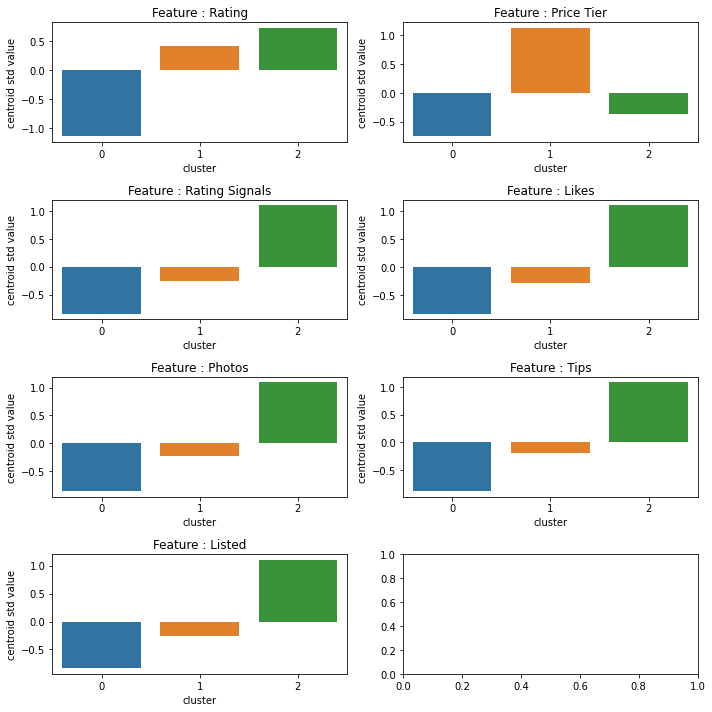

In [0]:
# Barplots for Centroids / Features
features = [
    'Rating',
    'Price Tier',
    'Rating Signals', 'Likes', 'Photos', 'Tips', 'Listed']

compare_features(df_centroids_std, features, figsize=(10,10))

In [0]:
# Grouped datasets for each Cluster.
restaurantcluster_0 = Cluster_Restaurants_Final.loc[Cluster_Restaurants_Final['Cluster Labels'] == 0, Cluster_Restaurants_Final.columns[[0,3,4,5,6,7,8,9,10,15]]]
restaurantcluster_1 = Cluster_Restaurants_Final.loc[Cluster_Restaurants_Final['Cluster Labels'] == 1, Cluster_Restaurants_Final.columns[[0,3,4,5,6,7,8,9,10,15]]]
restaurantcluster_2 = Cluster_Restaurants_Final.loc[Cluster_Restaurants_Final['Cluster Labels'] == 2, Cluster_Restaurants_Final.columns[[0,3,4,5,6,7,8,9,10,15]]]

In [0]:
restaurantcluster_0

,Cluster Labels,Rating,Rating Signals,Likes,Tips,Listed,Photos,Price Tier,Neighbourhood,Restaurant Category
0,0,8.5,28,18,10,33,4,2,"Cabbagetown, St. James Town",Indian Restaurant
2,0,8.2,45,30,17,56,35,2,"Cabbagetown, St. James Town",Italian Restaurant
3,0,8.2,25,16,9,14,12,2,"Cabbagetown, St. James Town",Restaurant
4,0,8.4,30,19,18,21,15,2,"Cabbagetown, St. James Town",Caribbean Restaurant
5,0,7.5,25,17,7,9,24,2,"Cabbagetown, St. James Town",Restaurant
...,...,...,...,...,...,...,...,...,...,...
124,0,6.0,13,7,1,3,3,2,"Chinatown, Grange Park, Kensington Market",Vietnamese Restaurant
125,0,7.8,48,27,16,32,38,2,Stn A PO Boxes 25 The Esplanade,Molecular Gastronomy Restaurant
126,0,7.4,15,6,7,6,7,2,Stn A PO Boxes 25 The Esplanade,Italian Restaurant
127,0,7.8,12,6,6,11,5,2,Christie,Italian Restaurant


In [0]:
restaurantcluster_1

,Cluster Labels,Rating,Rating Signals,Likes,Tips,Listed,Photos,Price Tier,Neighbourhood,Restaurant Category
1,1,8.8,161,113,54,186,262,2,"Cabbagetown, St. James Town",Japanese Restaurant
16,1,8.2,145,96,38,176,167,1,Church and Wellesley,Restaurant
31,1,8.4,266,182,55,170,309,4,Harbourfront,French Restaurant
37,1,7.7,298,173,114,64,247,2,"Ryerson, Garden District",Mexican Restaurant
39,1,7.5,317,197,91,46,386,2,"Ryerson, Garden District",Sushi Restaurant
42,1,8.0,198,106,82,59,222,2,"Ryerson, Garden District",Italian Restaurant
44,1,7.4,328,201,96,70,199,2,"Ryerson, Garden District",Middle Eastern Restaurant
49,1,8.9,99,74,23,96,185,4,St. James Town,Restaurant
51,1,8.0,219,142,45,162,158,3,St. James Town,Restaurant
52,1,7.7,115,69,36,35,97,3,St. James Town,Italian Restaurant


In [0]:
restaurantcluster_2

,Cluster Labels,Rating,Rating Signals,Likes,Tips,Listed,Photos,Price Tier,Neighbourhood,Restaurant Category
33,2,8.0,702,464,160,278,657,3,Harbourfront,Mexican Restaurant
35,2,8.2,440,306,123,304,484,2,"Ryerson, Garden District",Ramen Restaurant
38,2,8.7,596,388,224,709,644,2,"Ryerson, Garden District",Japanese Restaurant
41,2,7.4,453,263,113,73,587,2,"Ryerson, Garden District",Restaurant
72,2,9.3,902,686,206,845,466,2,"Adelaide, King, Richmond",Thai Restaurant
87,2,7.5,598,361,125,70,446,2,"Design Exchange, Toronto Dominion Centre",American Restaurant
100,2,9.1,388,299,98,683,258,1,"Chinatown, Grange Park, Kensington Market",Mexican Restaurant


## 7. Discussion Section


**Notes on the cluster's definitions:**

The Italian restaurant category is shared between Cluster 0 and 1. It may be possible that the Italian Restaurants in Cluster 0 are mostly fast food related (serving pizzas, takeaway).

High levels of Rating Signals, Likes, Photos, Listed, Tips not only may show high customer engagement, but also indicate that customers like to share their experiences in a venue, which can be interpreted as an implicit recommendation to eat in a given restaurant. 


In the chart below all clusters are visualized based on Rating (X axis), Restaurant Category (Y axis), Price Tier (hue) and Rating Signals (maker size). Cluster 1 and 2 show less variability in terms of Rating compared to Cluster 0.  Cluster 0 aggregates most of the restaurants with low Price Tier and low Rating Signals.  Cluster 2 has the lowest share of restaurants but with higher levels of customer engagements.



(0.0, 10.0)

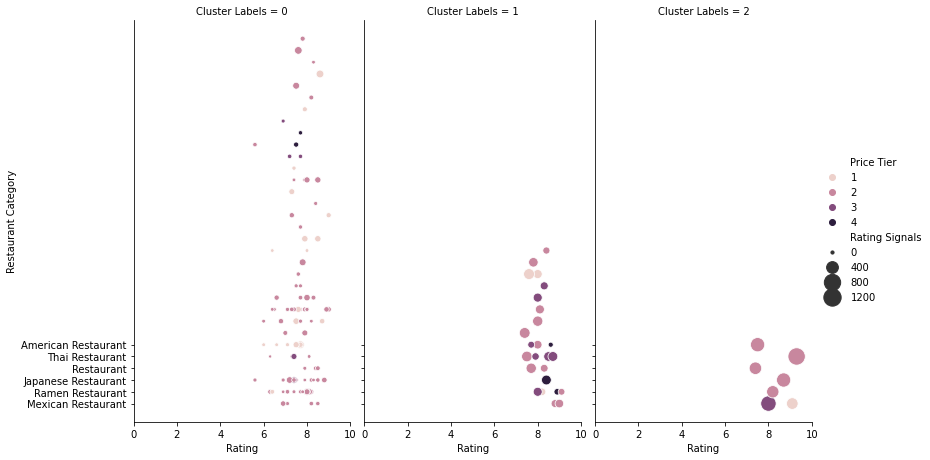

In [0]:
g_clusters = sns.relplot(height=6.5, y="Restaurant Category", col='Cluster Labels', x="Rating", hue="Price Tier", aspect=0.6, size="Rating Signals", data=Cluster_Restaurants_Final, alpha=1, sizes=(10,300), palette=sns.cubehelix_palette(4), facet_kws=dict(sharex=True))
g_clusters.axes[0,2].set_xlim(0,10)



## 8. Conclusion

By using an unsupervised machine learning algorithm like K-Prototypes, the Restaurants in Downtown Toronto can be classified in 3 clusters.  As indicated in the Results Section, the different restaurant categories (Restaurant features) have been grouped into:
Food Restaurants or Niche/Ethnic Restaurants (Cluster 0
Local and International Restaurants (Cluster 1)
International Restaurants (Cluster 2)

The Rating Signals, Rating and Price Tier features are plotted below.  As stated in the Discussion section, the scatter plot shows that:

Cluster 0 has the greatest variability in terms of Rating, low Rating Signals (less than 200) and Price Tear mostly between 1 and 2 (Cheap and Moderate).  Cluster 1 has a high Rating over 7.4, average Rating Signal but high Price Tier . Cluster 2 has a over 300 Rating Signals, the highest of all cluster combined with a high Rating.

Based on the cluster analysis,  each of the clusters can be defined as follows:

Cluster 0: Fast Food Restaurants or Niche/Ethnic Restaurants that mostly offer value for money. <br>
Cluster 1: Best Rated Fancy Local and International Restaurants<br>
Cluster 2: Best Rated and Recommended International Restaurants

This cluster analysis can be used by entrepeneurs trying to open a restaurant in Dowtown Toronto area.  For example what type of restaurant should an entrepenuer open in Central Bay Stree?  Looking at the Neighbourhoods by Cluster Labels countplot, it could be a Cluster 0 or Cluster 1 type of restaurant, since it seems that there is room to grow on those types of restaurantes compared to Church and Wellesley neighbourhood.  If an entrepenuer wants to open a restaurant with high customer engagement and word of mouth (Cluster 2), then Garden District or Harbourfront would be the suggested Neighbourhoods, as long as the restaurant is a quality International Restaurant.

For deeper analysis some other considerations like demographics, real state and land use should be also be considered for a suitable locaction.




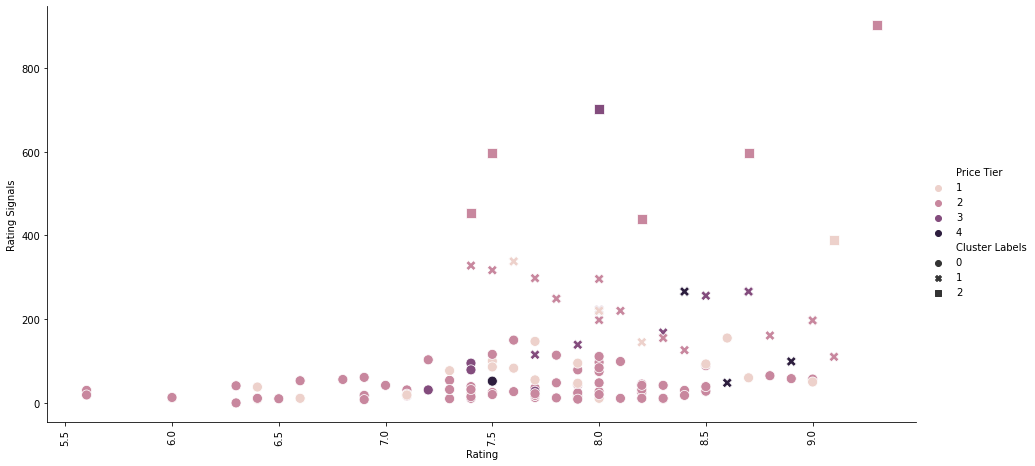

In [0]:

#Scatter Plot Features and respective Cluster Labels
g_final=sns.relplot(s=100, height=6.5, x="Rating", y="Rating Signals", hue="Price Tier", alpha=1, style="Cluster Labels",data=Cluster_Restaurants_Final, aspect=2)
g_final.set_xticklabels(rotation=90) #ratingvsRating Signals, hue price Tier, style Cluster labels



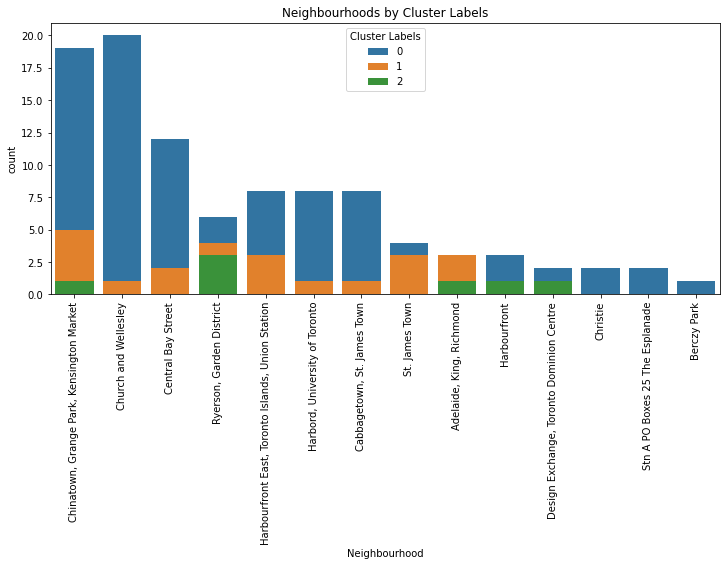

In [0]:
# Count Plot Restaurant Cluster Labels per Neighbourhood
f, ax1 = plt.subplots(1,1, figsize=(12,5))
descending_order = Cluster_Restaurants_Final['Neighbourhood'].value_counts().sort_values(ascending=False).index
sns.countplot(Cluster_Restaurants_Final['Neighbourhood'], ax=ax1, hue=Cluster_Restaurants_Final["Cluster Labels"], dodge=False, order=descending_order, palette=sns.color_palette())
ax1.set_title('Neighbourhoods by Cluster Labels')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90);

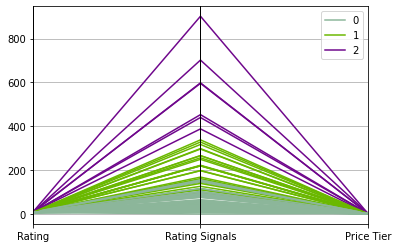

In [0]:
from pandas import plotting

pd.plotting.parallel_coordinates(Cluster_Restaurants_Final[['Cluster Labels','Rating','Rating Signals','Price Tier']].,'Cluster Labels')

plt.show()